<a href="https://colab.research.google.com/github/jnragu/classwork/blob/main/Project4_MLPython.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project 4

Build a mixture model for collaborative filtering. 

Given a data matrix containing movie ratings by users where the matrix is extracted from a much larger Netflix database. 

Any particular user has rated only a small fraction of movies so the data matrix is only partially filled. 

The goal is to prodect all the remanining entries of the matrix. 

We have $K$ possible types of users, and, in the context of each user, we must sample a user type and then the raing profile from the Gaussian distribution associated with the type. 

The Expectation Maximation (EM) algorithm will be used to estimate such a mixture from a partially obsereved rating matrix. The EM algorithm procceds by iteratiely assigning (softly) users to types (E-step) and subsequently re-estimating the Gaussians associated with each type (M-step). 

After this mixture is found, the missining entries in the data matrix can be predicted. 

## K-Means

Compare clustering obtained via K-means to the (soft) clustering induced by EM. 

The resulting clusters of points from the K-means algorithm will be used to estimate a Gaussian model for each cluster. Thus, the K-means algorithm returns a mixture model where the means of the component Gaussians are the $K$ centroids computed by the K-means algorithm, which is directly plotted to be compared to the EM algorithm, as if they were both estimating mixtures. 


### K-Means Algorithm

Given a set of feature vectors 
$$
S_n = \lbrace x^{(i)} | i = 1, \ldots n \rbrace
$$
and the number of clusters $K$, the K-means algorithm can be used to find reasonably good cluster assignments $C_1, \ldots, C_k$ and the representatives of each of the $K$ clusters $z_1, \ldots, z_k$ 

The algorithm is as follows:
1. Randomly select $z_1, \ldots, z_k$
2. Iterate 
  1. Given $z_1, \ldots, z_k$, assign each data point $x^{(i)}$ to the closest $z_j$ so that
  $$
    \text{Cost}(z_1, \ldots, z_K) = \sum_{i = 1}^{n}{\min_{j=1, \ldots, K}\lVert
x^{(i)} - z_j
\rVert}^2
  $$
  2. Given $C_1, \ldots, C_k$, find the best representatives $z_1, \ldots, z_K$, i.e., find $z_1, \ldots, z_K$ such that
  $$
  z_j = \text{argmin}_z\sum_{i \in C_j}^{}{\lVert
x^{(i)}-z
\rVert}^2
  $$

In [5]:
"""Mixture model for collaborative filtering"""
from typing import NamedTuple, Tuple
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.patches import Circle, Arc


class GaussianMixture(NamedTuple):
    """Tuple holding a gaussian mixture"""
    mu: np.ndarray  # (K, d) array - each row corresponds to a gaussian component mean
    var: np.ndarray  # (K, ) array - each row corresponds to the variance of a component
    p: np.ndarray  # (K, ) array = each row corresponds to the weight of a component


def init(X: np.ndarray, K: int,
         seed: int = 0) -> Tuple[GaussianMixture, np.ndarray]:
    """Initializes the mixture model with random points as initial
    means and uniform assingments

    Args:
        X: (n, d) array holding the data
        K: number of components
        seed: random seed

    Returns:
        mixture: the initialized gaussian mixture
        post: (n, K) array holding the soft counts
            for all components for all examples

    """
    np.random.seed(seed)
    n, _ = X.shape
    p = np.ones(K) / K

    # select K random points as initial means
    mu = X[np.random.choice(n, K, replace=False)]
    var = np.zeros(K)
    # Compute variance
    for j in range(K):
        var[j] = ((X - mu[j])**2).mean()

    mixture = GaussianMixture(mu, var, p)
    post = np.ones((n, K)) / K

    return mixture, post


def plot(X: np.ndarray, mixture: GaussianMixture, post: np.ndarray,
         title: str):
    """Plots the mixture model for 2D data"""
    _, K = post.shape

    percent = post / post.sum(axis=1).reshape(-1, 1)
    fig, ax = plt.subplots()
    ax.title.set_text(title)
    ax.set_xlim((-20, 20))
    ax.set_ylim((-20, 20))
    r = 0.25
    color = ["r", "b", "k", "y", "m", "c"]
    for i, point in enumerate(X):
        theta = 0
        for j in range(K):
            offset = percent[i, j] * 360
            arc = Arc(point,
                      r,
                      r,
                      0,
                      theta,
                      theta + offset,
                      edgecolor=color[j])
            ax.add_patch(arc)
            theta += offset
    for j in range(K):
        mu = mixture.mu[j]
        sigma = np.sqrt(mixture.var[j])
        circle = Circle(mu, sigma, color=color[j], fill=False)
        ax.add_patch(circle)
        legend = "mu = ({:0.2f}, {:0.2f})\n stdv = {:0.2f}".format(
            mu[0], mu[1], sigma)
        ax.text(mu[0], mu[1], legend)
    plt.axis('equal')
    plt.show()


def rmse(X, Y):
    return np.sqrt(np.mean((X - Y)**2))

def bic(X: np.ndarray, mixture: GaussianMixture,
        log_likelihood: float) -> float:
    """Computes the Bayesian Information Criterion for a
    mixture of gaussians

    Args:
        X: (n, d) array holding the data
        mixture: a mixture of spherical gaussian
        log_likelihood: the log-likelihood of the data

    Returns:
        float: the BIC for this mixture
    """
    raise NotImplementedError

In [6]:
"""Mixture model based on kmeans"""

from typing import NamedTuple, Tuple
import numpy as np

class GaussianMixture(NamedTuple):
    """Tuple holding a gaussian mixture"""
    mu: np.ndarray  # (K, d) array - each row corresponds to a gaussian component mean
    var: np.ndarray  # (K, ) array - each row corresponds to the variance of a component
    p: np.ndarray  # (K, ) array = each row corresponds to the weight of a component

def estep(X: np.ndarray, mixture: GaussianMixture) -> np.ndarray:
    """E-step: Assigns each datapoint to the gaussian component with the
    closest mean

    Args:
        X: (n, d) array holding the data
        mixture: the current gaussian mixture

    Returns:
        np.ndarray: (n, K) array holding the soft counts
            for all components for all examples

        """
    n, _ = X.shape
    K, _ = mixture.mu.shape
    post = np.zeros((n, K))

    for i in range(n):
        tiled_vector = np.tile(X[i, :], (K, 1))
        sse = ((tiled_vector - mixture.mu)**2).sum(axis=1)
        j = np.argmin(sse)
        post[i, j] = 1

    return post


def mstep(X: np.ndarray, post: np.ndarray) -> Tuple[GaussianMixture, float]:
    """M-step: Updates the gaussian mixture. Each cluster
    yields a component mean and variance.

    Args: X: (n, d) array holding the data
        post: (n, K) array holding the soft counts
            for all components for all examples

    Returns:
        GaussianMixture: the new gaussian mixture
        float: the distortion cost for the current assignment
    """
    n, d = X.shape
    _, K = post.shape

    n_hat = post.sum(axis=0)
    p = n_hat / n

    cost = 0
    mu = np.zeros((K, d))
    var = np.zeros(K)

    for j in range(K):
        mu[j, :] = post[:, j] @ X / n_hat[j]
        sse = ((mu[j] - X)**2).sum(axis=1) @ post[:, j]
        cost += sse
        var[j] = sse / (d * n_hat[j])

    return GaussianMixture(mu, var, p), cost


def run(X: np.ndarray, mixture: GaussianMixture,
        post: np.ndarray) -> Tuple[GaussianMixture, np.ndarray, float]:
    """Runs the mixture model

    Args:
        X: (n, d) array holding the data
        post: (n, K) array holding the soft counts
            for all components for all examples

    Returns:
        GaussianMixture: the new gaussian mixture
        np.ndarray: (n, K) array holding the soft counts
            for all components for all examples
        float: distortion cost of the current assignment
    """

    prev_cost = None
    cost = None
    while (prev_cost is None or prev_cost - cost > 1e-4):
        prev_cost = cost
        post = estep(X, mixture)
        mixture, cost = mstep(X, post)

    return mixture, post, cost

In [7]:
# Read the 2D toy dataset

X = np.loadtxt('/content/toy_data.txt')

### Run the K-means algorithm on the toy dataset. 

Initialize K-means using `common.init(X, K, seed)`, where $K$ is the number of clusters and `seed` is the random seed used to randomly initialize the parameters. 

`init(X, K)` returns a K-component misture model with means, variances, and mixing porportions. 
The K-means algorithm only cares about the means, however, and returns a mixture that is retrofitted based on the K-means solution. 

Try $K = [1, 2, 3, 4]$ on the data using seeds $0, 1, 2, 3, 4$ and plot each solution using the `plot` function 

#### $K = 1$

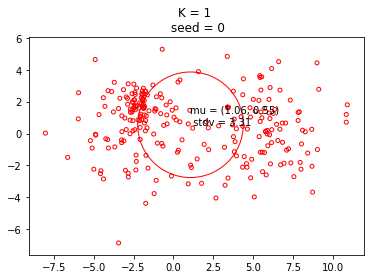

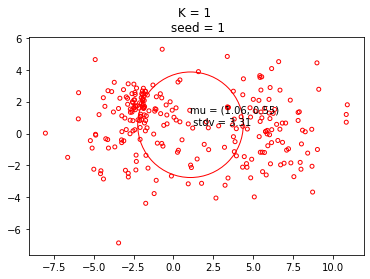

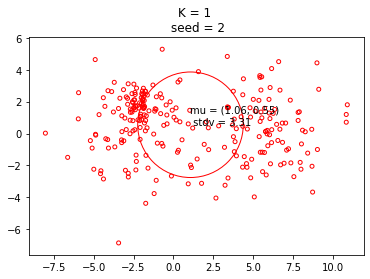

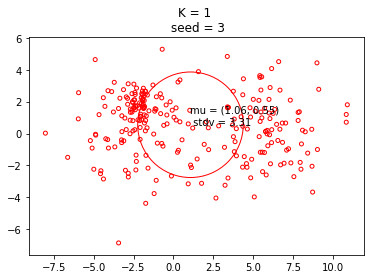

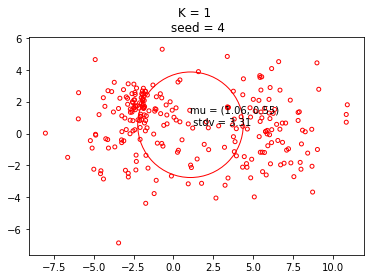

seed 0 cost = 5462.297452340002
seed 1 cost = 5462.297452340002
seed 2 cost = 5462.297452340002
seed 3 cost = 5462.297452340002
seed 4 cost = 5462.297452340002


In [27]:
seeds = [0, 1, 2, 3, 4]
K = 1
costs = []

for seed in seeds:
  mixture, post = init(X, K = K, seed = seed)
  mixture, post, cost = run(X, mixture, post)
  plot(X, mixture, post, f'K = 1 \n seed = {seed}')
  costs.append(cost)

for seed in seeds:
  print(f'seed {seed} cost = {costs[seed]}')

#### $K = 2$

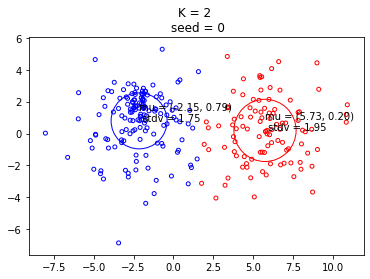

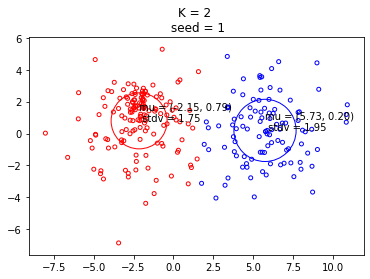

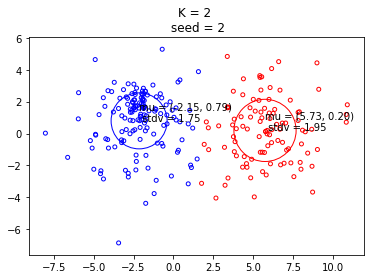

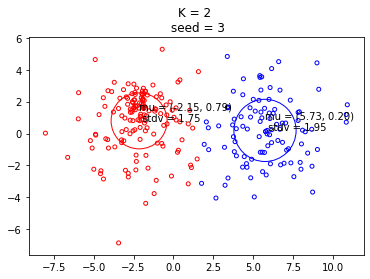

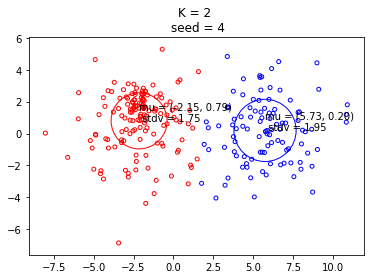

seed 0 cost = 1684.9079502962372
seed 1 cost = 1684.9079502962372
seed 2 cost = 1684.9079502962372
seed 3 cost = 1684.9079502962372
seed 4 cost = 1684.9079502962372


In [30]:
seeds = [0, 1, 2, 3, 4]
K = 2
costs = []

for seed in seeds:
  mixture, post = init(X, K = K, seed = seed)
  mixture, post, cost = run(X, mixture, post)
  plot(X, mixture, post, f'K = {K} \n seed = {seed}')
  costs.append(cost)

for seed in seeds:
  print(f'seed {seed} cost = {costs[seed]}')

#### $K = 3$

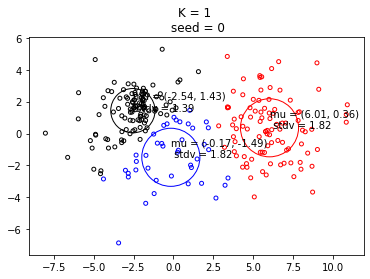

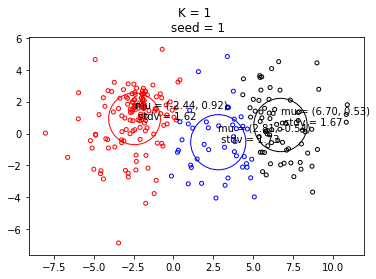

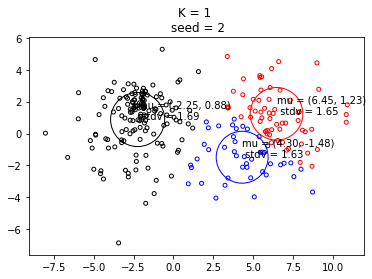

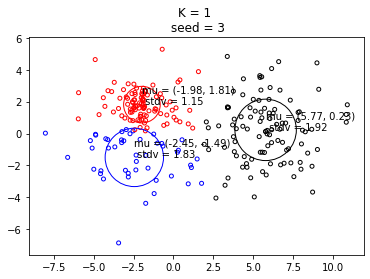

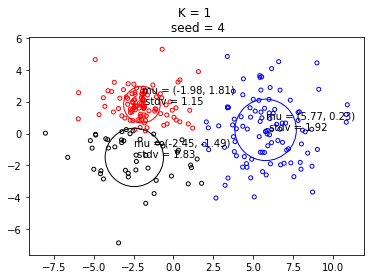

seed 0 cost = 1336.8265256618938
seed 1 cost = 1369.5619965862434
seed 2 cost = 1396.6396874064844
seed 3 cost = 1329.59486715443
seed 4 cost = 1329.59486715443


In [31]:
seeds = [0, 1, 2, 3, 4]
K = 3
costs = []

for seed in seeds:
  mixture, post = init(X, K = K, seed = seed)
  mixture, post, cost = run(X, mixture, post)
  plot(X, mixture, post, f'K = 1 \n seed = {seed}')
  costs.append(cost)

for seed in seeds:
  print(f'seed {seed} cost = {costs[seed]}')

#### $K = 4$

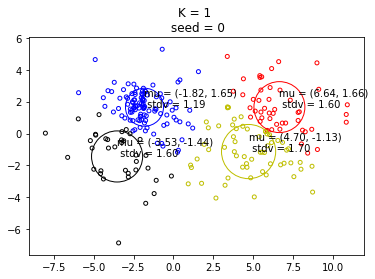

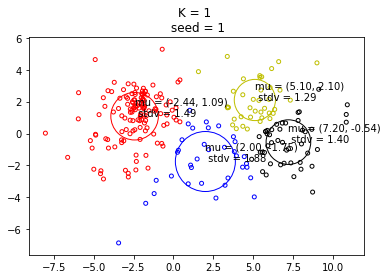

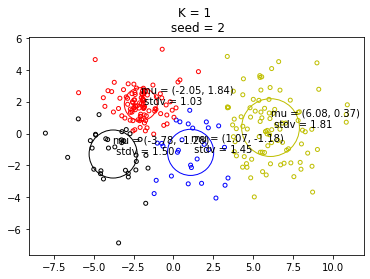

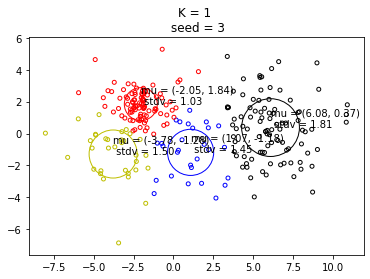

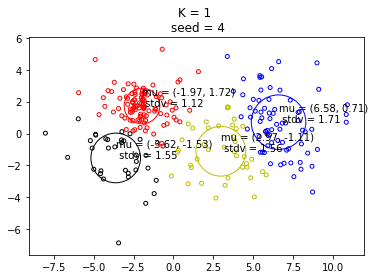

seed 0 cost = 1069.3964259219192
seed 1 cost = 1134.8086773780892
seed 2 cost = 1075.3348748905864
seed 3 cost = 1075.3348748905864
seed 4 cost = 1035.499826539466


In [32]:
seeds = [0, 1, 2, 3, 4]
K = 4
costs = []

for seed in seeds:
  mixture, post = init(X, K = K, seed = seed)
  mixture, post, cost = run(X, mixture, post)
  plot(X, mixture, post, f'K = 1 \n seed = {seed}')
  costs.append(cost)

for seed in seeds:
  print(f'seed {seed} cost = {costs[seed]}')

## Expectation-Maximation Algorithm

The Gaussian mixture model is
$$
P(x|\theta) = \sum_{j=1}^{K}{\pi_j N (x; \mu^{(j)}, \sigma_j^2I)}
$$
where $\theta$ denotes all the parameters in the mixture 
- $\mu^{(j)}$: means 
- $\pi_j$: mixing proportions
- $\sigma^2_j$: variances 

The goal of the EM algorithm is to estimate these unknown parameters by maximixing the log-likelihood of the observed data $x^{(i)}, \ldots, x^{(n)}$

Starting with some initial guess of the unknown parameters, the algorithm iterates between E- and M- steps. 
- The E-step softly assigns each data point $x^{(i)}$ to mixure components
- The M-step takes these soft-assignments as given and finds a new setting of the parameters by maximizing the log-lielihood of the weighted dataset (expected complete log-likelohood)

Implement the Gaussian mixture model. 
- `x`: an $(n,d)$ NumPy array of $n$ data points, each with $d$ features
- `K`: number of mixture components
- `mu`: $(K, d)$ NumPy array where the $j^{th}$ row is the mean vector $\mu^{(j)}$
- `p`: $(K,)$ NumPy array of mixing proportions $\pi_j, j = 1, \ldots, K$
- `var`: $(K,)$ NumPy array of variances $\sigma_j^2, j=1, \ldots, K$

The convergence criteria you should use is that the improvement in the log-likelihood is less than or equal to $10^{-6}$ multiplied by the absolute value of the new log-likelihood. 
$$
\text{new log-likelihood} - \text{old log-likelihood} \leq 10^{-6} \cdot | \text{new log-likelihood} |
$$

A few notes:
- EM should monotonically increase the log-likelihood of the data. Initialize and run the EN algorithm on the toy dataset. Check that the `LL` values that the algorithm returns after each run are indeed always monotonically increasing (non-decreasing)
- Using $K = 3$ and seed of $0$ on the toy dataset, you should get a log likelihood of `-1388.0818` after the first iteration

### EM Algorithm 
1. Randomly initalize the estimate $\hat\theta$
2. Iterate
  1. E-step
$$
\text{update} \quad p(j \mid i ) = p\big[j \text{ generated }x^{(i)} \mid x^{(i)},\theta\big], \quad \text{for } j = 1, \ldots, K \quad i = 1, \ldots, n
$$
  2. M-step
$$
\begin{align*}
	\hat l (x ^{(i)}, \ldots, x^{(n)}) = \sum_{i=1}^{n}{\sum_{j=1}^{K}{p(j \mid i) \log{\frac{p(x^{(i)}\text{ generated by }j)}{p(j \mid i)}}}} \\
p(x^{(i)}\text{ generated by }j \mid \theta ) = p_j \cdot p(x^{(i)} \mid \mu^{(j)}, \sigma^2_jI)
\end{align*}
$$

In [81]:
"""Mixture model based on EM"""

def estep(X: np.ndarray, mixture: GaussianMixture) -> Tuple[np.ndarray, float]:
    """E-step: Softly assigns each datapoint to a gaussian component
    Args:
        X: (n, d) array holding the data
        mixture: the current gaussian mixture
    Returns:
        np.ndarray: (n, K) array holding the soft counts
            for all components for all examples
        float: log-likelihood of the assignment
    """
    n, d = X.shape
    mu, var, pi = mixture
    K = mu.shape[0]
    
    # Compute normal dist. matrix: (N, K)
    pre_exp = (2*np.pi*var)**(d/2)
    
    # Calc exponent term: norm matrix/(2*variance)
    post = np.linalg.norm(X[:,None] - mu, ord=2, axis=2)**2   # Vectorized version
    post = np.exp(-post/(2*var))
    
    post = post/pre_exp     # Final Normal matrix: will be (n, K)

    numerator = post*pi
    denominator = np.sum(numerator, axis=1).reshape(-1,1) # This is the vector p(x;theta)
 
    post = numerator/denominator    # p(j|i)
    
    log_likelihood = np.sum(np.log(denominator), axis=0).item()    # Log-likelihood
    
    return post, log_likelihood

def mstep(X: np.ndarray, post: np.ndarray) -> GaussianMixture:
    """M-step: Updates the gaussian mixture by maximizing the log-likelihood
    of the weighted dataset
    Args:
        X: (n, d) array holding the data
        post: (n, K) array holding the soft counts
            for all components for all examples
    Returns:
        GaussianMixture: the new gaussian mixture
    """
    n, d = X.shape
    K = post.shape[1]
    
    nj = np.sum(post, axis=0)   # shape is (K, )
    
    pi = nj/n   # Cluster probs; shape is (K, )
    
    mu = (np.matmul(post.transpose(), X )) / nj.reshape(-1,1)
    
    norms = np.linalg.norm(X[:, None] - mu, ord = 2, axis = 2)**2    # Vectorized version

    var = np.sum(post*norms, axis=0)/(nj*d)     # Revised variance; shape is (K, )
    
    return GaussianMixture(mu, var, pi)

def run(X: np.ndarray, mixture: GaussianMixture,
        post: np.ndarray) -> Tuple[GaussianMixture, np.ndarray, float]:
    """Runs the mixture model
    Args:
        X: (n, d) array holding the data
        post: (n, K) array holding the soft counts
            for all components for all examples
    Returns:
        GaussianMixture: the new gaussian mixture
        np.ndarray: (n, K) array holding the soft counts
            for all components for all examples
        float: log-likelihood of the current assignment
    """
    old_log_likelihood = None
    new_log_likelihood = None  # Keep track of log likelihood to check convergence
    
    # Start the main loop
    while old_log_likelihood is None or (new_log_likelihood - old_log_likelihood > 1e-6*np.abs(new_log_likelihood)):
        
        old_log_likelihood = new_log_likelihood
        
        # E-step
        post, new_log_likelihood = estep(X, mixture)
        
        # M-step
        mixture = mstep(X, post)
            
    return mixture, post, new_log_likelihood

## Comparing K-means and EM
For each value of $K = [1, 2, 3, 4]$ using seeds $0, 1, 2, 3, 4$ run the EM algorithm

#### $K = 1$

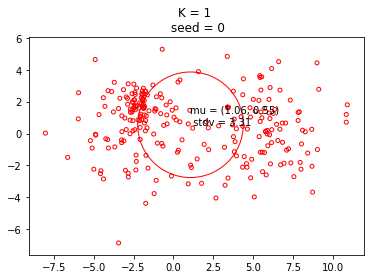

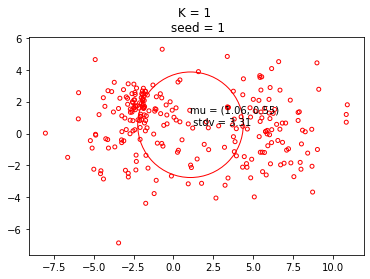

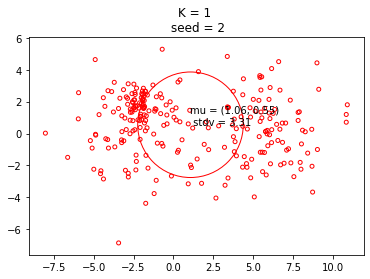

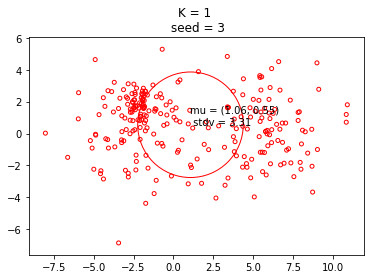

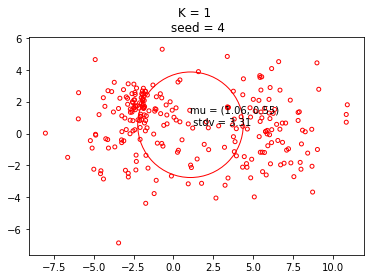

seed 0 log-likelihood = -1307.2234317600935
seed 1 log-likelihood = -1307.2234317600935
seed 2 log-likelihood = -1307.2234317600935
seed 3 log-likelihood = -1307.2234317600935
seed 4 log-likelihood = -1307.2234317600935


In [88]:
seeds = [0, 1, 2, 3, 4]
K = 1
log_likelihoods = []

for seed in seeds:
  mixture, post = init(X, K = K, seed = seed)
  mixture, post, log_likelihood = run(X, mixture, post)
  plot(X, mixture, post, f'K = {K} \n seed = {seed}')
  log_likelihoods.append(log_likelihood)

for seed in seeds:
  print(f'seed {seed} log-likelihood = {log_likelihoods[seed]}')

#### $K = 2$

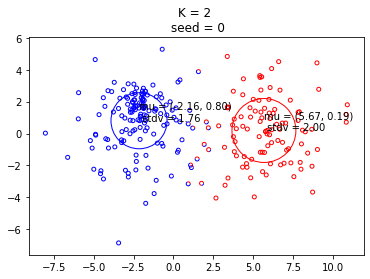

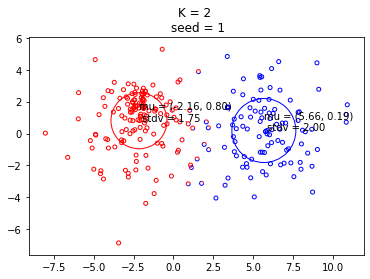

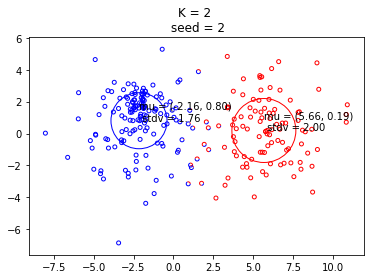

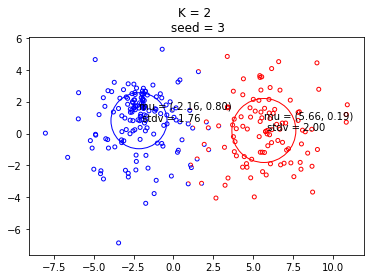

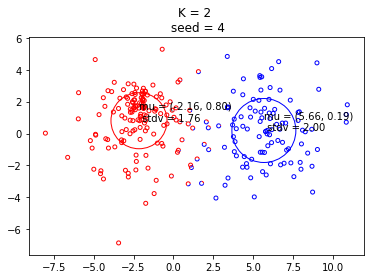

seed 0 log-likelihood = -1175.714685005802
seed 1 log-likelihood = -1175.7148637279554
seed 2 log-likelihood = -1175.7146293666797
seed 3 log-likelihood = -1175.7146708423365
seed 4 log-likelihood = -1175.7146484290492


In [89]:
seeds = [0, 1, 2, 3, 4]
K = 2
log_likelihoods = []

for seed in seeds:
  mixture, post = init(X, K = K, seed = seed)
  mixture, post, log_likelihood = run(X, mixture, post)
  plot(X, mixture, post, f'K = {K} \n seed = {seed}')
  log_likelihoods.append(log_likelihood)

for seed in seeds:
  print(f'seed {seed} log-likelihood = {log_likelihoods[seed]}')

#### $K=3$

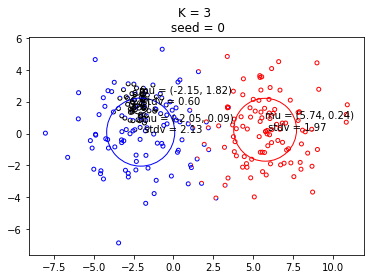

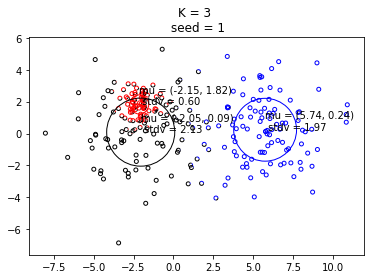

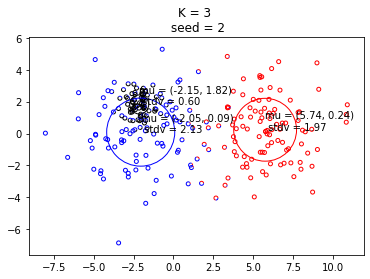

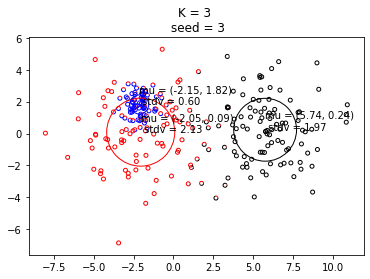

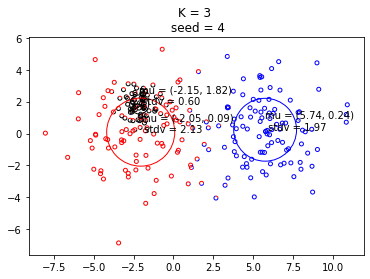

seed 0 log-likelihood = -1138.890899687267
seed 1 log-likelihood = -1138.891526858204
seed 2 log-likelihood = -1138.8913232476145
seed 3 log-likelihood = -1138.8909601749283
seed 4 log-likelihood = -1138.8910558011275


In [90]:
seeds = [0, 1, 2, 3, 4]
K = 3
log_likelihoods = []

for seed in seeds:
  mixture, post = init(X, K = K, seed = seed)
  mixture, post, log_likelihood = run(X, mixture, post)
  plot(X, mixture, post, f'K = {K} \n seed = {seed}')
  log_likelihoods.append(log_likelihood)

for seed in seeds:
  print(f'seed {seed} log-likelihood = {log_likelihoods[seed]}')

#### $K = 4$

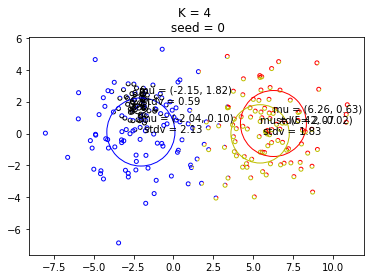

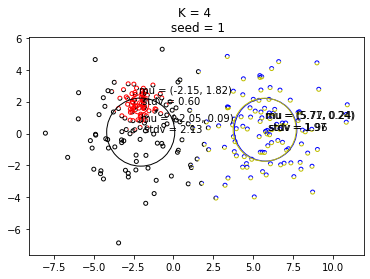

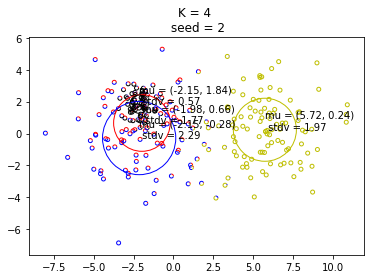

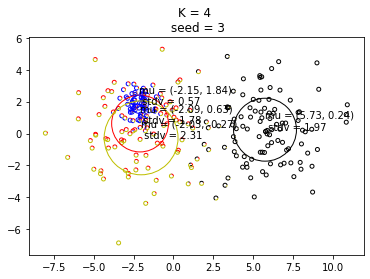

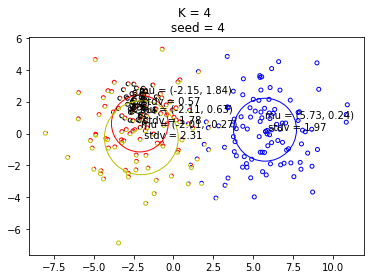

seed 0 log-likelihood = -1138.6978681199805
seed 1 log-likelihood = -1138.891045633598
seed 2 log-likelihood = -1138.6035882684878
seed 3 log-likelihood = -1138.601578916819
seed 4 log-likelihood = -1138.601175699485


In [91]:
seeds = [0, 1, 2, 3, 4]
K = 4
log_likelihoods = []

for seed in seeds:
  mixture, post = init(X, K = K, seed = seed)
  mixture, post, log_likelihood = run(X, mixture, post)
  plot(X, mixture, post, f'K = {K} \n seed = {seed}')
  log_likelihoods.append(log_likelihood)

for seed in seeds:
  print(f'seed {seed} log-likelihood = {log_likelihoods[seed]}')

## Baysian Information Criterion

So far, the number of mixture components $K$ has been set, but this is also a paremter that must be estimated. 

The Bayesian information criterion (BIC) is a criterion for model selection which captures the tradeoff between the log-likelihood of the data, and the number of parameters that the model uses. 

The BIC of a model $M$ is defined as 
$$
\text{BIC}(M) = l - \frac{1}{2} p \log{n}
$$

- $l$ is the log-likelihood of the data under the current model (highest log-likelihood we can achieve by adjusting the parameters in the model) 

- $p$ is the number of free parameters

- $n$ is the number of data points

This score reqards a larger log-likelihood, but peanlizes the number of parameters used to train the model. In the situation where we wish to select models, we want a model with the highest BIC. 


### Implementing the Bayesian Information Criterion

In [95]:
def bic(X: np.ndarray, mixture: GaussianMixture,
        log_likelihood: float) -> float:
    """Computes the Bayesian Information Criterion for a
    mixture of gaussians

    Args:
        X: (n, d) array holding the data
        mixture: a mixture of spherical gaussian
        log_likelihood: the log-likelihood of the data

    Returns:
        float: the BIC for this mixture
    """

    n = X.shape[0]
    p = 0 

    for index, value in enumerate(mixture): 
      if index == 0:
        p += value.shape[0] * value.shape[1]
      else: 
        p += value.shape[0]

    p -= 1

    bic = log_likelihood - 0.5 * p * np.log(n)

    return bic

### Picking the best K

Find the best $K$ from $[1,2,3,4]$ on the toy dataset for the EM model.
This will be the $K$ that produces the optimal BIC score. 

In [97]:
K_vals = [1, 2, 3, 4]
seed = 0
scores = []

for K in K_vals:
  mixture, post = init(X, K = K, seed = seed)
  mixture, post, log_likelihood = run(X, mixture, post)
  score = bic(X, mixture, log_likelihood)
  BIC_scores.append(score)
  print(f'K = {K}: BIC score = {score}')

K = 1: BIC score = -1315.505623136887
K = 2: BIC score = -1195.03979821832
K = 3: BIC score = -1169.2589347355092
K = 4: BIC score = -1180.1088250039475


## Mixture models for matrix completion 

Now the Gaussian mixture model can be extended to predict actual movie ratings. 

Let $X$ denote the $(n,d)$ data matrix. 
- Rows: users
- Columns: movies 

Therefore, `X[u, i]` gives the rating value of user $u$ for movie $i$ (if available). 

Both $n$ and $d$ are typically quite large. 

The ratings range from one to five stars and are mapped to integers $\lbrace 1, 2, 3, 4, 5 \rbrace $ . 

Set `X[u,i] = 0` whenever the entry is missing. 

In a realistic setting, most of the entries of $X$ are missing. 
For this reason, we define 
- $C_u$: the set of movies (column indices) that user $u$ has rated 
- $H_u$: as it's complement (the set of remaining unwatched/unrated movies we wish to predict the ratings for) 


Use $\mid C_u \mid$ to denote the number of observed rating values from user $u$. 

From the point of view of our mixture model, each user $u$ is an example $x^{(u)} =$ `X[u:]`. 

But since most of the coordinates of $x^{(u)}$ are missing, we need to focus the model during training on just the observed portion. 

To this end, we use $x_{C_u}^{(u)} = \lbrace x_i^{(u)}: i \in C_u \rbrace$ as the vector of only observed ratings. 

If columns are indexed as $\lbrace 0 , \ldots, d-1\rbrace$, then a user $u$ with a rating vector $x^{(u)} = (5, 4, 0, 0, 2)$, where zeros indicate missing values, has $C_u = \lbrace 0, 1, 4\rbrace, H_u = \lbrace 2, 3\rbrace$, and $x_{C_i}^{(u)} = (5, 4, 2)$


#### The mixture model will be extended in two key ways
- We will estimate a mixture model based on partially observed ratings
- Since we will be dealing with large, high-dimensional dataset, we will need to be more mindful of numerical underflow issues. 
  - Perform mose of the computations in the log domain 
  - Remember, $\log{a \cdot b} = \log{a} + \log{b}$
  - This can be useful to remember when $a$ and $b$ are very small - in these cases, addition should result in fewer numerical underflow issues than multiplication 

#### LogSumExp Trick
An additional numerical optimization trick that you will find useful is the `LogSumExp` trick. 

Assume that we wish to evaluate $y = \log{(\exp{(x_1)} + \ldots \exp{(x_n)})} $. 

1. Define $x^* = \max{\lbrace x_1, \ldots, x_n \rbrace}$. 
2. $ y=x^*+\log (\exp (x_{1}-x^*)+...\exp (x_{n}-x^*)) $

This is another trick to help ensure numerical stability.

#### Marginalizing under unobserved coordinates

If $x^{(u)}$ were a complete rating vector, the mixture model would simply say that
$$
  P(x^{(u)}|\theta )=\sum _{j=1}^{K}\pi _{j}N(x^{(u)};\mu ^{(j)},\sigma _{j}^{2}I)
$$

In the presence of missing values, we must use the marginal probability $P_{C_u}^{(u)} \mid \theta)$ that is over only the observed values. 
- This marginal corresponds to integrating the mixture density $P(x^{(u)} \mid \theta )$ over all the unobserved coordinate values. In this our case, this marginal can be computed as follows. 

The mixture for a complete rating vector is written as 
$$
  P(x^{(u)} \mid \theta ) = \sum_{j=1}^{K}{p_j N (x^{(u)}; \mu^(j), \sigma_j^2I}
$$

We can decompose the multivariate spherical Gaussian as a product of univariate Gaussians (since there is no covariance between coordinates
$$
\begin{align*}
	  P(x^{(u)} \mid \theta) &=  \sum ^{K}_{j=1} p_ j \prod _ i N(x_ i^{(u)}; \mu _ i^{(j)}, \sigma _ i^{2,(j)}) \\
  &= \sum ^{K}_{j=1} p_ j \prod _{m \in C_ u} N(x_ m^{(u)}; \mu _ m^{(j)}, \sigma _ m^{2,(j)}) \prod _{m' \in H_ u} N(x_{m'}^{(u)}; \mu _{m'}^{(j)}, \sigma _{m'}^{2,(j)})
\end{align*}
$$

For $m' H_u$, we can marginalize over all the unobserved values to get 
$$
  \int N(x_{m'}^{(u)}; \mu _{m'}^{(j)}, \sigma _{m'}^{2,(j)}) dx_{m'}^{(u)} = 1
$$

Thus, our mixture density can be written as 
$$
  P(x_{C_ u}^{(u)} | \theta ) = \sum ^{K}_{j=1} p_ j N(x_{C_ u}^{(u)}; \mu _{C_ u}^{(j)}, \sigma _ j^{2}I_{|C_ u| \times |C_ u|})
$$
Where $I_{\mid C_u \mid \times \mid C_u \mid}$ is the identity matrix in $\mid C_u \mid $ dimensions. 

## Implementing EM for matrix completion

Need to update the EM algorithm to deal with the fact that the observations are no longer complete vectors. 

Use Baye's rule to find an updated expression for the posterior probability $p(j \mid u) = P(y = j \mid x^{(u)}_{C_u}) $
$$
p(j\mid u) =\frac{p(u|j)\cdot p(j)}{p(u)} =\frac{p(u|j)\cdot p(j)}{\sum _{j=1}^{K}p(u|j)\cdot p(j)} =\frac{ \pi _{j}N(x_{C_{u}}^{(u)};\mu _{C_{u}}^{(j)},\sigma _{j}^{2}I_{C_{u}\times C_{u}}) }{ \sum _{j=1}^{K}\pi _{j}N(x_{C_{u}}^{(u)};\mu _{C_{u}}^{(j)},\sigma _{j}^{2}I_{C_{u}\times C_{u}}) }
$$

This is the soft assignment of cluster $j$ to data point $u$. 


### E-step

To minimize the numerical instability, re-implement the E-stem in the log-domain, so calculate the values for the log of the posterior probability, $\ell(j, u) = \log{(p(j\mid u))}$ (through the actual output of your E-step should include the non-log posterior). 

Let $f(u,i)=\log (\pi _{i})+\log \left(N(x_{C_{u}}^{(u)};\mu _{C_{u}}^{(i)},\sigma _{i}^{2}I_{C_{u}\times C_{u}})\right)$. 

Then, in terms of $f$, the log posterior is:

$$
\begin{align*}
	\ell(j \mid u) &= \log{(p(j\mid u))} \\
  &= \log \Bigg(\frac{\pi_j N(x_{C_u}^{(u)}; \mu_{C_u}^{(j)}, \sigma^2_jI_{C_u \times C_u})}{\sum_{j=1}^{K}{\pi_j} N(x_{C_u}^{(u)}; \mu_{C_u}^{(j)}, \sigma^2_jI_{C_u \times C_u})} \Bigg) \\
  &= \log\Big({\pi_j N(x_{C_u}^{(u)}; \mu_{C_u}^{(j)}, \sigma^2_jI_{C_u \times C_u})} \Big) - \log \Bigg({\sum_{j=1}^{K}{\pi_j }N(x_{C_u}^{(u)}; \mu_{C_u}^{(j)}, \sigma^2_jI_{C_u \times C_u})} \Bigg) \\
  &= \log{(\pi_j)} + \log {N(x_{C_u}^{(u)}; \mu_{C_u}^{(j)}, \sigma^2_jI_{C_u \times C_u})} - \log \Bigg( {\sum_{j=1}^{K}{\pi_j }N(x_{C_u}^{(u)}; \mu_{C_u}^{(j)}, \sigma^2_jI_{C_u \times C_u}) \Bigg)} \\
  &= f(u, j) - \log \Bigg( {\sum_{j=1}^{K}{\exp{(f(u,j))}}} \Bigg)
\end{align*}
$$

In [109]:
from scipy.special import logsumexp

def estep(X: np.ndarray, mixture: GaussianMixture) -> Tuple[np.ndarray, float]:
    """E-step: Softly assigns each datapoint to a gaussian component

    Args:
        X: (n, d) array holding the data, with incomplete entries (set to 0)
        mixture: the current gaussian mixture

    Returns:
        np.ndarray: (n, K) array holding the soft counts
            for all components for all examples
        float: log-likelihood of the assignment

    """

    n, d = X.shape
    mu, var, pi = mixture   
    K = mu.shape[0]

    # Create a delta matrix to indicate where X is non-zero, which will help us pick Cu indices
    delta = X.astype(bool).astype(int)
    # Exponent term: norm matrix/(2*variance)
    f = (np.sum(X**2, axis=1)[:,None] + (delta @ mu.T**2) - 2*(X @ mu.T))/(2*var) # This is using indicator matrix: fastest of all
    # Pre-exponent term: A matrix of shape (n, K)
    pre_exp = (-np.sum(delta, axis=1).reshape(-1,1)/2.0) @ (np.log((2*np.pi*var)).reshape(-1,1)).T
    # Put them together
    f = pre_exp - f
    
######## End: vectorized version ########
    
    f = f + np.log(pi + 1e-16)  # This is the f(u,j) matrix
    
    # log of normalizing term in p(j|u)
    logsums = logsumexp(f, axis=1).reshape(-1,1)  # Store this to calculate log_lh
    log_posts = f - logsums # This is the log of posterior prob. matrix: log(p(j|u))
    
    log_lh = np.sum(logsums, axis=0).item()   # This is the log likelihood
    
    return np.exp(log_posts), log_lh



### M-step

We wish to find the parameters $\pi, \mu$, and $\sigma$ that maximize $\ell(X; \theta)$

By decomposing the multivariate spherical Gaussians into univariate spherical Gaussians, we can write 

if $l \in C_u$

$$
\begin{align*}
  \frac{\partial }{\partial \mu _ l^{(k)}} N(x_{C_{u}}^{(u)}|\mu _{C_{u}}^{(k)},\sigma _{k}^{2}I_{|C_{u}|\times |C_{u}|}) &=  N(\dots ) \frac{ \frac{\partial }{\partial \mu _ l^{(k)}} \left(\frac{1}{\sqrt{2\pi } \sigma _{l,(k)}} \exp (-\frac{1}{2\sigma _{l,(k)}^2} (x^{(u)}_ l - \mu _ l^{(k)})^2 ) \right) }{ \left(\frac{1}{\sqrt{2\pi } \sigma _{l,(k)}} \exp (-\frac{1}{2\sigma _{l,(k)}^2} (x^{(u)}_ l - \mu _ l^{(k)})^2 ) \right) } \\
  &= N(\dots ) \frac{x_ l^{(u)} - \mu _ l^{(k)}}{\sigma _{l,(k)}^2}
\end{align*}
$$

where $N(\dots ) = N(x_{C_{u}}^{(u)}|\mu _{C_{u}}^{(k)},\sigma _{k}^{2}I_{|C_{u}|\times |C_{u}|})$

If $l \not\in C_u$, that derivative is $0$. To cover both cases, we can write
$$
\frac{\partial }{\partial \mu _ l^{(k)}} N(x_{C_{u}}^{(u)}|\mu _{C_{u}}^{(k)},\sigma _{k}^{2}I_{|C_{u}|\times |C_{u}|}) = N(x_{C_{u}}^{(u)}|\mu _{C_{u}}^{(k)},\sigma _{k}^{2}I_{|C_{u}|\times |C_{u}|}) \delta (l,C_ u) \frac{x_ l^{(u)} - \mu _ l^{(k)}}{\sigma _{l,(k)}^2}
$$
where $\delta(i, C_u)$ is an indicator function: $1$ if $i \in C_u$ and zero otherwise. 

Following the EM algorithm's approach of maximizing a proxy likelihood function $\hat\ell(X; \theta)$ during M step, consider the following funciton
$$
\begin{align*}
	\hat\ell(X; \theta) &= \sum _{u = 1}^ n \sum _{j = 1}^ K p(j \mid u) \log \left(\frac{p\left( x^{(u)} \text { generated by cluster } j ; \theta \right)}{p(j \mid u)}\right) \\
  &= \sum _{u = 1}^ n \sum _{j = 1}^ K p(j \mid u) \log \left(\frac{\pi _ j \mathcal{N}(x_{C_ u}^{(u)} \mid \mu _{C_ u}^{(j)}, \sigma _ j^2 I_{|C_ u| \times |C_ u|})}{p(j \mid u)}\right)
\end{align*}
$$
where $p\left( x^{(u)} \text { generated by cluster } j ; \theta \right)$ is the likelihood of $x^{(u)}$ generaged by cluster $j$ and the parameter set is $\theta$. 

The values $p(j\mid u)$ are the ones that were computed in the E-step and they are constants for the M-stem. 

Now, take the derivative of $\hat\ell(X; \theta)$ with respect to $\mu^{(k)}_l$ to find the optimal value of $\mu_l^{(k)}$ that maximized $\hat\ell(X;\theta)$.

$$
\begin{align*}
	\frac{\partial \hat{\ell }(X;\theta )}{\partial \mu _ l^{(k)}} &= - \frac{\partial }{\partial \mu _ l^{(k)}} \left[\sum _{u = 1}^ n \sum _{j = 1}^ K p(j \mid u) \cdot \frac{1}{2} \cdot \frac{\|  x_{C_ u}^{(u)} - \mu _{C_ u}^{(j)}\| ^2}{\sigma _ j^2} \right] \\
  &= \sum _{u = 1}^ n p(k \mid u) \delta (l,C_ u) \frac{x_ l ^{(u)} - \mu _ l^{(k)}}{\sigma _ k^2},
\end{align*}
$$
where $\delta (i, C_u) = 1$ if $i \in C_u$ and $\delta(i, C_u) = 0$ if $i \not in C_u$. 

Setting the partial derivative equal to zero, we obtain 
$$
\widehat{\mu _ l^{(k)}} = \frac{\sum _{u = 1}^ n p(k \mid u) \delta (l,C_ u) x_ l^{(u)}}{\sum _{u=1}^ n p(k \mid u) \delta (l,C_ u)}.
$$
To obtain the estimates of $\sigma_j^2$ and $\pi_k$ for $k = 1, \ldots, K$. \
$$
 \begin{align*}
	 \widehat{\sigma _ k^2} &=  \frac{1}{\sum _{u=1}^ n |C_ u| p(k \mid u)} \sum _{u = 1}^ n p(k \mid u) \| x_{C_ u}^{(u)} - \widehat{\mu _{C_ u}^{(k)}}\| ^2 \\
 \widehat{\pi _ k}&= \frac{1}{n} \sum _{u=1}^ n p(k \mid u).
 \end{align*}
$$



In [112]:
def mstep(X: np.ndarray, post: np.ndarray, mixture: GaussianMixture,
          min_variance: float = .25) -> GaussianMixture:
    """M-step: Updates the gaussian mixture by maximizing the log-likelihood
    of the weighted dataset

    Args:
        X: (n, d) array holding the data, with incomplete entries (set to 0)
        post: (n, K) array holding the soft counts
            for all components for all examples
        mixture: the current gaussian mixture
        min_variance: the minimum variance for each gaussian

    Returns:
        GaussianMixture: the new gaussian mixture
    """
    n, d = X.shape
    mu, var, pi = mixture   
    K = mu.shape[0]

    pi = np.sum(post, axis = 0) / n

    # Create delta matrix indicating where X is non-zero
    delta = X.astype(bool).astype(int)

    # Update means only when sum_u(p(j|u)*delta(l,Cu)) >= 1
    numerator = np.matmul(post.transpose(), X) # Numerator (K,d)
    denominator = np.matmul(post.transpose(), delta) # Denominator (K,d): Only include dims that have information
    
    update_indices = np.where(denominator >= 1)   # Indices for update
    mu[update_indices] = numerator[update_indices]/denominator[update_indices] # Only update where necessary (denom>=1)
    
    # Update variances
    denominator_var = np.sum(post*np.sum(delta, axis=1).reshape(-1,1), axis=0) # Shape: (K,)
    
    norms = np.sum(X**2, axis=1)[:,None] + (delta @ mu.transpose()**2) - 2*(X @ mu.transpose())
    
######## End: vectorized version #########
    
    # Revised var: if var(j) < 0.25, set it = 0.25
    var = np.maximum(np.sum(post*norms, axis=0)/denominator_var, min_variance)  
    
    return GaussianMixture(mu, var, pi)

def run(X: np.ndarray, mixture: GaussianMixture,
        post: np.ndarray) -> Tuple[GaussianMixture, np.ndarray, float]:
    """Runs the mixture model

    Args:
        X: (n, d) array holding the data
        post: (n, K) array holding the soft counts
            for all components for all examples

    Returns:
        GaussianMixture: the new gaussian mixture
        np.ndarray: (n, K) array holding the soft counts
            for all components for all examples
        float: log-likelihood of the current assignment
    """
    old_log_likelihood = None
    new_log_likelihood = None  # Keep track of log likelihood to check convergence
    
    # Start the main loop
    while old_log_likelihood is None or (new_log_likelihood - old_log_likelihood > 1e-6*np.abs(new_log_likelihood)):
        
        old_log_likelihood = new_log_likelihood
        
        # E-step
        post, new_log_likelihood = estep(X, mixture)
        
        # M-step
        mixture = mstep(X, post, mixture)
            
    return mixture, post, new_log_likelihood

# Using the mixture model for collaborative filtering

## Log-likelihood values on Netflix data

Run the EM algorithm on the incomplete data from Netflix ratings.

Use seeds from $[0,1,2,3,4]$ and test $K=1$ and $K=12$

In [115]:
X = np.loadtxt('/content/netflix_incomplete.txt')

### K = 1

In [116]:
seeds = [0, 1, 2, 3, 4]
K = 1
log_likelihoods = []

for seed in seeds:
  mixture, post = init(X, K = K, seed = seed)
  mixture, post, log_likelihood = run(X, mixture, post)
  log_likelihoods.append(log_likelihood)

for seed in seeds:
  print(f'seed {seed} log-likelihood = {log_likelihoods[seed]}')

seed 0 log-likelihood = -1521060.9539852473
seed 1 log-likelihood = -1521060.9539852473
seed 2 log-likelihood = -1521060.9539852473
seed 3 log-likelihood = -1521060.9539852473
seed 4 log-likelihood = -1521060.9539852473


### K = 12

In [117]:
seeds = [0, 1, 2, 3, 4]
K = 12
log_likelihoods = []

for seed in seeds:
  mixture, post = init(X, K = K, seed = seed)
  mixture, post, log_likelihood = run(X, mixture, post)
  log_likelihoods.append(log_likelihood)

for seed in seeds:
  print(f'seed {seed} log-likelihood = {log_likelihoods[seed]}')

seed 0 log-likelihood = -1399803.0466569138
seed 1 log-likelihood = -1390234.4223469393
seed 2 log-likelihood = -1416862.4011512804
seed 3 log-likelihood = -1393521.3929897747
seed 4 log-likelihood = -1416733.8083763553


## Complete missing entries

Now that we have the mixture model, how do we use it to complete a partially observed rating matrix? 

In [118]:
def fill_matrix(X: np.ndarray, mixture: GaussianMixture) -> np.ndarray:
    """Fills an incomplete matrix according to a mixture model

    Args:
        X: (n, d) array of incomplete data (incomplete entries =0)
        mixture: a mixture of gaussians

    Returns
        np.ndarray: a (n, d) array with completed data
    """
    n, d = X.shape
    mu, var, pi = mixture
    K = mu.shape[0]
    
    X_pred = X.copy()
    missing = np.where(X == 0)

    delta = X.astype(bool).astype(int)

    f = (np.sum(X**2, axis=1)[:,None] + (delta @ mu.T**2) - 2*(X @ mu.T))/(2*var) # This is using indicator matrix: fastest of all
    pre_exp = (-np.sum(delta, axis=1).reshape(-1,1)/2.0) @ (np.log((2*np.pi*var)).reshape(-1,1)).T
    f = pre_exp - f
    
    #f(u, j)
    f = f + np.log(pi + 1e-16)  
    
    # log of normalizing term in p(j|u)
    logsums = logsumexp(f, axis=1).reshape(-1,1)  # Store this to calculate log_lh
        
    X_pred[missing] = np.matmul(np.exp(f - logsums), mu)[missing]

    return X_pred


## Comparing with gold targets

Test the accuracy of your predictions against actual target values by loading the complete metrics and measure the root mean squared error between the two matrices using the best mixture for $K = 12$

In [123]:
X = np.loadtxt('/content/netflix_incomplete.txt')
X_gold = np.loadtxt('/content/netflix_complete.txt')

In [124]:
def rmse(X, Y):
    return np.sqrt(np.mean((X - Y)**2))

In [126]:
mixture, post = init(X, K = 12, seed = 1)
mixture, post, log_likelihood = run(X, mixture, post)

X_pred = fill_matrix(X, mixture)

rmse(X_gold, X_pred)

0.4804908505400685